In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.iotools import read_tmy3
from pvlib.pvsystem import PVSystem, FixedMount, Array
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.location import Location
import datetime
import pytz
import os
import itertools
import inspect
import calendar
import h5py
from pvlib import pvsystem, location, modelchain, iotools,tools
import pathlib
from dataclasses import dataclass
from pvlib import tracking
from netCDF4 import num2date
from requests.exceptions import HTTPError
from xml.etree.ElementTree import ParseError
from pvlib.irradiance import campbell_norman, get_extra_radiation, disc, louche, erbs_driesse, ghi_from_poa_driesse_2023
from pvlib.irradiance import _liujordan, get_total_irradiance
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import warnings
from pvlib._deprecation import deprecated
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

In [2]:
#import pytz

In [3]:
#pytz.country_timezones('US')

In [4]:
#BSRN QC
data_path ='ABQ2017QC.csv'
df = pd.read_csv(data_path, index_col=[0], parse_dates=[0])
#df.index = df.index.tz_localize('America/Phoenix')  # Make the index timezone aware
original_entries = df.shape[0]
df.head(2)  # Print the first two lines of the DataFrame

,solar_zenithX,ghi,dhi,dni,temp_air,relative_humidity
DATE,,,,,,
2017-01-01 00:00:00+00:00,89.27,18.6,24.3,1.0,22.50,47.82
2017-01-01 00:01:00+00:00,89.42,16.8,22.4,0.8,22.58,48.12


In [5]:
#df.dropna()

In [6]:
ghi=df['ghi']
dhi=df['dhi']
dni=df['dni']
temp_air=df['temp_air']
relative_humidity=df['relative_humidity']
#tcc=df['tcc']
#ghi_cs=df['ghi_cs']
#dhi_cs=df['dhi_cs']
#dni_cs=df['dni_cs']

In [7]:
latitude=35.03796 ; longitude=-106.62211; altitude=1617.0 ; tz='America/Phoenix'
location = Location(latitude,longitude,name='ABQ', altitude=1617.0, tz=tz)
datetime_or_doy=df.index
times=df.index
times

DatetimeIndex(['2017-01-01 00:00:00+00:00', '2017-01-01 00:01:00+00:00',
               '2017-01-01 00:02:00+00:00', '2017-01-01 00:03:00+00:00',
               '2017-01-01 00:04:00+00:00', '2017-01-01 00:05:00+00:00',
               '2017-01-01 00:06:00+00:00', '2017-01-01 00:07:00+00:00',
               '2017-01-01 00:08:00+00:00', '2017-01-01 00:09:00+00:00',
               ...
               '2017-12-31 23:50:00+00:00', '2017-12-31 23:51:00+00:00',
               '2017-12-31 23:52:00+00:00', '2017-12-31 23:53:00+00:00',
               '2017-12-31 23:54:00+00:00', '2017-12-31 23:55:00+00:00',
               '2017-12-31 23:56:00+00:00', '2017-12-31 23:57:00+00:00',
               '2017-12-31 23:58:00+00:00', '2017-12-31 23:59:00+00:00'],
              dtype='datetime64[ns, UTC]', name='DATE', length=525598, freq=None)

In [8]:
solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
apparent_zenith = solpos['apparent_zenith']
zenith = solpos['zenith']
solar_zenith=solpos['apparent_zenith']
azimuth = solpos['azimuth']
equation_of_time=solpos['equation_of_time']
cos_solar_zenith=tools.cosd(solar_zenith)
pressure = pvlib.atmosphere.alt2pres(altitude)
linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, latitude,longitude)
apparent_elevation = solpos['apparent_elevation']
dni_extra=pvlib.irradiance.get_extra_radiation(times, solar_constant=1367, method='spencer', epoch_year=2017)
airmass_relative=pvlib.atmosphere.get_relative_airmass(apparent_zenith, model='gueymard2003')
#airmass_relative=pvlib.atmosphere.get_relative_airmass(apparent_zenith, model='kastenyoung1989')
absolute_airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

In [9]:
df['temp_dew'] = df['temp_air']-((100-df['relative_humidity'])/5)
temp_dew=df['temp_dew']

In [10]:
df['pw'] = (np.exp(0.07 * df.temp_dew - 0.075))

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
solar_zenithX,525598.0,89.682857,38.588171,11.600000,58.420000,89.260000,121.190000,168.400000
ghi,519632.0,230.931159,332.350841,-10.000000,-5.900000,1.400000,435.300000,1388.800000
dhi,525596.0,58.688211,89.665608,-0.700000,0.300000,6.500000,81.600000,649.900000
dni,525182.0,284.306205,384.584577,-10.000000,0.000000,0.800000,721.000000,1041.700000
temp_air,525598.0,19.399912,5.674663,1.869000,15.560000,19.320000,23.210000,37.680000
relative_humidity,525598.0,52.192262,20.770877,5.086000,35.650000,51.220000,68.830000,98.000000
temp_dew,525598.0,9.838364,5.104931,-9.163000,6.004000,10.932000,13.930000,20.860000
pw,525598.0,1.959845,0.634152,0.488503,1.412385,1.994194,2.459849,3.995625


In [12]:
df['zenith']=zenith
df['solar_zenith']=solar_zenith
#cos_solar_zenith=tools.cosd(solar_zenith)
df['cos_solar_zenith']=cos_solar_zenith
df['dni_extra']=dni_extra
df['ghi_extra'] = dni_extra * cos_solar_zenith
#df['ghi_extra']=ghi_extra
#df['dni_extra']=dni_extra
#df['k_t']=df['ghi']/df['ghi_extra']  # clearness index
df['equation_of_time']=equation_of_time
hour_angle=pvlib.solarposition.hour_angle(times, longitude, equation_of_time)
df['hour_angle']=hour_angle
# apparent solar time
ast = hour_angle / 15 + 12
# quality check asserted in the original Engerer2 R code.
ast[ast < 0] = abs(ast[ast < 0])
df['ast']=ast
df['airmass']=airmass_relative

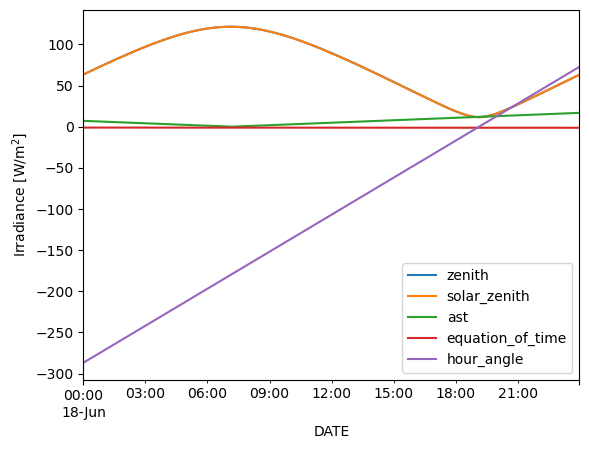

In [13]:
df.loc['2017-06-18', ['zenith','solar_zenith','ast','equation_of_time','hour_angle']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [14]:
clearsky, meta =pvlib.iotools.get_cams(latitude=latitude, longitude=longitude, start=df.index[0], end=df.index[-1], email='brightmabasa@gmail.com',
                                       identifier='mcclear', altitude=altitude, time_step='1min', time_ref='UT', verbose=False, integrated=False, label=None, map_variables=True, server='api.soda-solardata.com', timeout=30)

In [15]:
df['ghi_cs']=clearsky['ghi_clear']
df['dni_cs']=clearsky['dni_clear']
df['dhi_cs']=clearsky['dhi_clear']
#bhi_Mclear=clearsky['bhi_clear']
df['ghi_extra_Mclear']=clearsky['ghi_extra']

In [16]:
#clearsky, meta =pvlib.iotools.get_cams(latitude=latitude, longitude=longitude, start=df.index[0], end=df.index[-1], email='brightmabasa@gmail.com',
                                       #identifier='mcclear', altitude=altitude, time_step='1min', time_ref='UT', verbose=False, integrated=False, label=None, map_variables=True, server='api.soda-solardata.com', timeout=30)

In [17]:
#ghi_Mclear=clearsky['ghi_clear']
#dni_Mclear=clearsky['dni_clear']
#dhi_Mclear=clearsky['dhi_clear']
#bhi_Mclear=clearsky['bhi_clear']
#ghi_extra_Mclear=clearsky['ghi_extra']
#IP = pvlib.clearsky.ineichen(apparent_zenith, absolute_airmass, linke_turbidity, altitude, dni_extra,perez_enhancement=True)
#Ineichen.to_csv('INPUPN20160724M.csv')

#ghi_clearIP=IP['ghi']
#dni_clearIP=IP['dni']
#dhi_clearIP=IP['dhi']

#Mabasa_GHIc=cs['ghi']
#Mabasa_DNIc=cs['dni']
#Mabasa_DHIc=cs['dhi']
#ghi_clear=cs['ghi']
#dni_clear=cs['dni']
#dhi_clear=cs['dhi']

#df['ghi_cs']=ghi_clearIP
#df['dhi_cs']=dhi_clearIP
#df['dni_cs']=dni_clearIP

#df['ghi_cs']=ghi_Mclear
#df['dhi_cs']=dhi_Mclear
#df['dni_cs']=dni_Mclear
#df['bhi_Mclear']=bhi_Mclear
#df['ghi_extra_Mclear']=ghi_extra_Mclear

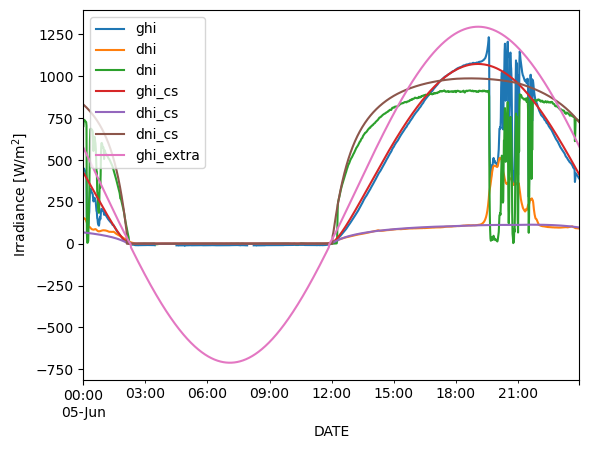

In [18]:
#It is often helpful to visualize the data in order to check that the measurements are within the expected ones. 
df.loc['2017-06-05', ['ghi','dhi','dni','ghi_cs','dhi_cs','dni_cs','ghi_extra']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [19]:
#df.to_csv('abq_2017_qc5.csv')

In [20]:
# add k_t, k_tcsi, k_tc, dk_tc, k_de columns
#ghi_extra = dni_extra * tools.cosd(solar_zenith)
#df['ghi_extra']=ghi_extra
#df['dni_extra']=dni_extra
df['kn']=df['dni']/df['dni_extra'] #beam fraction
df['k_t']=df['ghi']/df['ghi_extra']  # clearness index
df['k_d']=df['dhi']/df['ghi'] # diffuse fraction
df['k_tcsi'] = df['ghi'] / df['ghi_cs'] #cloud_enhancement_estimate= df['ghi'] - df['ghi_clear']
df['k_tc'] = df['ghi_cs'] / df['ghi_extra']  #k_tc is the clear-sky clearness index = ghi,cs/e_exth.
df['dk_tc'] = df['k_tc'] - df['k_t'] #deviation of kt from k_tc #clearness index deviation #delta_kc
df['k_de'] = np.maximum(0,1-df['ghi_cs']/df['ghi']) #Proportion of kd attributable to cloud enhancement #cloud_enhancement_estimate / df['ghi']
df['k_tprime'] = df['k_t']/(1.031*np.exp(-1.4/(0.9+9.4*df['airmass']))+0.1) 
df.columns

Index(['solar_zenithX', 'ghi', 'dhi', 'dni', 'temp_air', 'relative_humidity',
       'temp_dew', 'pw', 'zenith', 'solar_zenith', 'cos_solar_zenith',
       'dni_extra', 'ghi_extra', 'equation_of_time', 'hour_angle', 'ast',
       'airmass', 'ghi_cs', 'dni_cs', 'dhi_cs', 'ghi_extra_Mclear', 'kn',
       'k_t', 'k_d', 'k_tcsi', 'k_tc', 'dk_tc', 'k_de', 'k_tprime'],
      dtype='object')

In [21]:
df['K_t'] = df.groupby([df.index.get_level_values('DATE').floor('H')])['k_t'].transform('mean') #Kt_hourly
df['K_tdaily'] = df.groupby([df.index.get_level_values('DATE').date])['k_t'].transform('mean')  #Kt_daily
#df

In [22]:
H=df.resample('H').mean().reindex(df.index, method="ffill")
D=df.resample('D').mean().reindex(df.index, method="ffill")
df['K_T']=H['k_t']
df['K_D']=D['K_t']

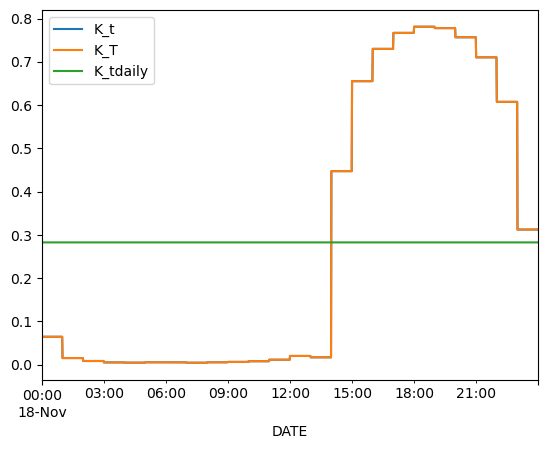

In [23]:
df.loc['2017-11-18', ['K_t','K_T','K_tdaily']].plot()
plt.legend()

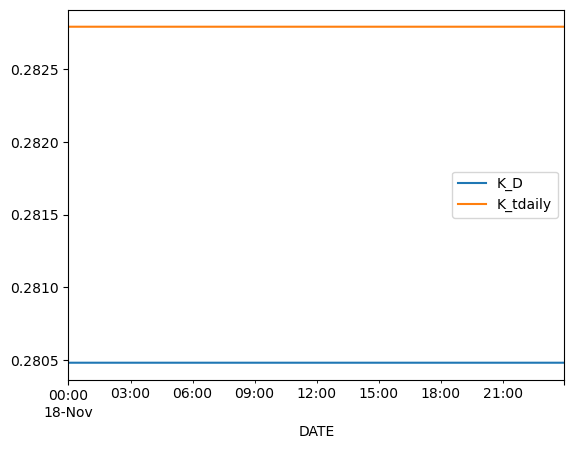

In [24]:
df.loc['2017-11-18', ['K_D','K_tdaily']].plot()
plt.legend()

In [25]:
# Calculate VI for each minute
rho = df['ghi'] / df['ghi_cs']
rho_minus1 = rho.shift(1)
rho_plus1 = rho.shift(-1)

VI = np.sqrt(((rho - rho_minus1.fillna(rho_plus1)) ** 2 + (rho - rho_plus1.fillna(rho_minus1)) ** 2) / 2)
VI[rho_minus1.isna() & np.invert(rho_plus1.isna())] = np.abs(rho - rho_plus1)
VI[rho_plus1.isna() & np.invert(rho_minus1.isna())] = np.abs(rho - rho_minus1)
VI[rho_minus1.isna() & rho_plus1.isna()] = np.where(rho<1.04,0.021+0.397*rho-0.231*rho**2-0.13*np.exp(-(((rho-0.931)/0.134)**2)**0.834),0.12+0.65*(rho-1.04))

df['VI_s'] = VI

In [26]:
ktprime = df['k_tprime']
ktprime_m1 = ktprime.shift(1)
ktprime_p1 = ktprime.shift(-1)

# Calculate VI_perez for each minute
VI_perez = 0.5 * (abs(ktprime - ktprime_m1.fillna(ktprime_p1)) + abs(ktprime - ktprime_p1.fillna(ktprime_m1)))

VI_perez[ktprime_m1.isna() & ktprime_p1.isna()] = 0
df['VI_p'] = VI_perez

In [27]:
df['persistence'] = np.nanmean([df['k_t'].shift(), df['k_t'].shift(-1)],axis=0) #persistence
df.head()

C:\Users\Brighton.Mabasa\AppData\Local\Temp\ipykernel_23116\2043185968.py:1: RuntimeWarning: Mean of empty slice
  df['persistence'] = np.nanmean([df['k_t'].shift(), df['k_t'].shift(-1)],axis=0) #persistence


,solar_zenithX,ghi,dhi,dni,temp_air,relative_humidity,temp_dew,pw,zenith,solar_zenith,...,dk_tc,k_de,k_tprime,K_t,K_tdaily,K_T,K_D,VI_s,VI_p,persistence
DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00+00:00,89.27,18.6,24.3,1.0,22.50,47.82,12.064,2.158643,89.882084,89.417608,...,-1.293296,1.0,1.148584,-0.267523,0.148084,-0.267523,0.148084,NaN,0.261416,1.588039
2017-01-01 00:01:00+00:00,89.42,16.8,22.4,0.8,22.58,48.12,12.204,2.179902,90.061831,89.571604,...,-1.588039,1.0,1.410000,-0.267523,0.148084,-0.267523,0.148084,NaN,0.540152,1.902108
2017-01-01 00:02:00+00:00,89.56,17.1,22.6,0.1,22.65,47.42,12.134,2.169247,90.241822,89.724223,...,-2.510921,1.0,2.228887,-0.267523,0.148084,-0.267523,0.148084,NaN,1.895016,3.723697
2017-01-01 00:03:00+00:00,89.69,18.0,23.4,0.0,22.68,48.10,12.300,2.194600,90.422056,89.875601,...,-5.859356,1.0,5.200033,-0.267523,0.148084,-0.267523,0.148084,NaN,2.971146,-11.820108
2017-01-01 00:04:00+00:00,89.82,16.8,22.4,0.0,22.74,47.85,12.310,2.196137,90.602531,90.026014,...,26.151137,1.0,NaN,-0.267523,0.148084,-0.267523,0.148084,NaN,NaN,1.502631


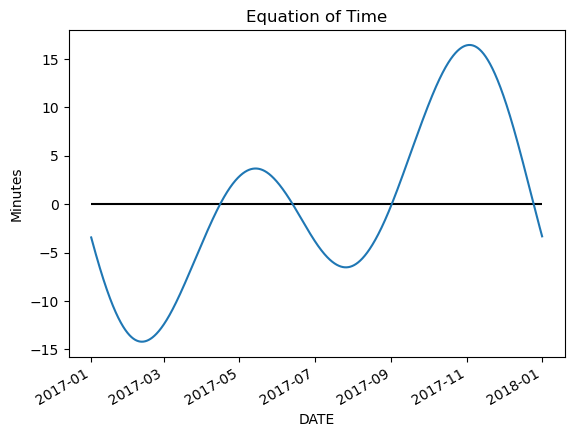

In [28]:
fig, ax1 = plt.subplots()
ax1 = solpos['equation_of_time'].plot(zorder=2)
ax1.hlines(0, solpos.index[0], solpos.index[-1], color='black', zorder=1)
ax1.set_ylabel('Minutes')
plt.title('Equation of Time')
plt.show()

In [29]:
#df = df[df['zenith'] < 85]

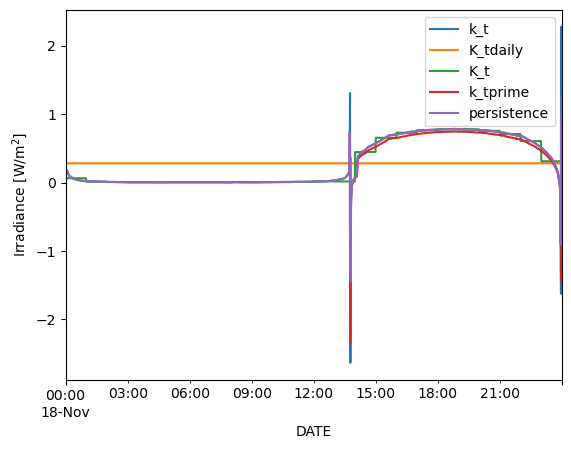

In [30]:
df.loc['2017-11-18', ['k_t','K_tdaily','K_t','k_tprime','persistence']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [31]:
#Erbs, Klein and Duffie (1982) Estimation of the diffuse radiation fraction for hourly, daily and monthly-average global radiation,Solar Energy, Vol. 28(4), pp. 293-302, Equation 1
#def _predict_K(self, data, **kwargs):
        #daytime = data['sza'] < self._max_sza
        #Kt = data.ghi.divide(data.eth).where(daytime, np.nan)
        #K = 0.9511 - 0.1604*Kt + 4.388*Kt**2 - 16.638*Kt**3 + 12.336*Kt**4
        #K.loc[Kt <= 0.22] = 1. - 0.09*Kt.loc[Kt <= 0.22]
        #K.loc[Kt > 0.8] = 0.165
        #return K.clip(0., 1.)
erbs = pvlib.irradiance.erbs(ghi, solar_zenith, times)
erbs=erbs.fillna(0)
#erbs.columns
#erbs.to_csv('ERBS_2017_DNI_AB.csv')
df['dni_erbs']=erbs['dni']
dni_erbs=df['dni_erbs']
df['dhi_erbs']=erbs['dhi']
dhi_erbs=df['dhi_erbs']
df['kd_erbs']=df['dhi_erbs']/df['ghi']
kd_erbs=df['kd_erbs']

In [32]:
erbs_driesse=pvlib.irradiance.erbs_driesse(ghi, solar_zenith, times, dni_extra, min_cos_zenith=0.065, max_zenith=87)
erbs_driesse.columns
#erbs_driesse.to_csv('ERBSD_2017_DNI_AB.csv')
df['dni_erbsD']=erbs_driesse['dni']
dni_erbsD=df['dni_erbsD']
df['dhi_erbsD']=erbs_driesse['dhi']
dhi_erbsD=df['dhi_erbsD']
df['kd_erbsD']=df['dhi_erbsD']/df['ghi']
kd_erbsD=df['kd_erbsD']

In [33]:
#Equation 11 In:Hollands (1985) A derivation of the diffuse fraction's dependence on the clearness index. Solar Energy, Vol. 35, pp. 131-136.
#required__ = ['sza', 'eth', 'ghi']
#def _predict_K(self, data, **kwargs):
        #daytime = data['sza'] < self._max_sza
        #Kt = data.ghi.divide(data.eth).where(daytime, np.nan)
        #tau_u = 0.897
        #omega_l = 0.982
        #a = 1. / tau_u
        #b = 0.5*omega_l
        #B = 1. - b
        #K = (B - (B**2 - 4*a*(b**2)*Kt*(1-a*Kt)).pow(0.5)).divide(2*a*b*Kt)
        #return K.clip(0., 1.)
orgill_hollands=pvlib.irradiance.orgill_hollands(ghi, solar_zenith, times, dni_extra, min_cos_zenith=0.065, max_zenith=87)
#orgill_hollands.to_csv('OHM_2017_DNI_AB.csv')
df['dni_ohm']=orgill_hollands['dni']
dni_ohm=df['dni_ohm']
df['dhi_ohm']=orgill_hollands['dhi']
dhi_ohm=df['dhi_ohm']
df['kd_ohm']=df['dhi_ohm']/df['ghi']
kd_ohm=df['kd_ohm']
#orgill_hollands.columns

In [34]:
louche=pvlib.irradiance.louche(ghi, solar_zenith, times, max_zenith=90)
#louche.to_csv('LOUCHE_2017_DNI_AB.csv')
df['dni_louche']=louche['dni']
dni_louche=df['dni_louche']
df['dhi_louche']=louche['dhi']
dhi_louche=df['dhi_louche']
df['kd_louche']=df['dhi_louche']/df['ghi']
kd_louche=df['kd_louche']
#louche.columns

In [35]:
boland = pvlib.irradiance.boland(ghi, solar_zenith, times, a_coeff=7.997, b_coeff=0.586, min_cos_zenith=0.065, max_zenith=87)
boland = boland.rename(columns={'dni': 'dni_boland', 'dhi': 'dhi_boland'})
#boland.to_csv('BOLAND_2017_DNI_AB.csv')
df['dni_boland']=boland['dni_boland']
dni_boland=df['dni_boland']
df['dhi_boland']=boland['dhi_boland']
dhi_boland=df['dhi_boland']
df['kd_boland']=df['dhi_boland']/df['ghi']
kd_boland=df['kd_boland']
#boland.columns

In [36]:
#Section 3.3 In:Maxwell, E. L., "A Quasi-Physical Model for Converting Hourly Global Horizontal to Direct Normal Insolation", Technical Report No.SERI/TR-215-3087, Golden, CO: Solar Energy Research Institute, 1987.
#Code adapted from pvlib:https://github.com/pvlib/pvlib-python/tree/master/pvlib/irradiance.py
#required__ = ['sza', 'eth', 'ghi']
#def _predict_K(self, data, **kwargs):
        #daytime = data['sza'] < self._max_sza
        #Kt = data.ghi.divide(data.eth).where(daytime, np.nan)
        #a = 0.512 - 1.56*Kt + 2.286*Kt**2 - 2.222*Kt**3
        #a = a.where(Kt <= 0.6, -5.743 + 21.77*Kt - 27.49*Kt**2 + 11.56*Kt**3)
        #b = 0.37 + 0.962*Kt
        #b = b.where(Kt <= 0.6, 41.4 - 118.5*Kt + 66.05*Kt**2 + 31.9*Kt**3)
        #c = -0.28 + 0.932*Kt - 2.048*Kt**2
        #c = c.where(Kt <= 0.6, -47.01 + 184.2*Kt - 222.0*Kt**2 + 73.81*Kt**3)
        #sza = data['sza']
        #cosz = np.cos(np.radians(sza))
        #am = (1. / (cosz + .15 * (93.885 - sza)**(-1.253))).clip(1, 12)
        #delta_Kn = a + b * np.exp(c*am)
        #Knc = 0.866 - 0.122*am + 0.0121*am**2 - 0.000653*am**3 + 1.4e-05*am**4
        #Kn = (Knc - delta_Kn).clip(0., 1.)
        #K = 1. - Kn.divide(Kt).where(Kt > 0., np.nan)
        #return K.clip(0., 1.)
# DISC method estimated with absolute airmass as input
disc = pvlib.irradiance.disc(ghi, solar_zenith, times, pressure) # Site pressure in Pascal
disc=disc.fillna(0)
#disc
#disc.to_csv('DISC_2017_DNI_AB.csv')
df['dni_disc']=disc['dni']
dni_disc=df['dni_disc']
df['dhi_disc']=df['ghi']-df['dni_disc']* cos_solar_zenith
dhi_disc=df['dhi_disc']
df['kd_disc']=df['dhi_disc']/df['ghi']
kd_disc=df['kd_disc']

In [37]:
#Perez et al. (1992) Dynamic global-to-direct irradiance conversion models, ASHRAE Transactions, Vol. 98(1), pp. 354/369
#Code adapted from pvlib: https://github.com/pvlib/pvlib-python/tree/master/pvlib/irradiance.py
#required__ = ['eth', 'sza', 'ghi']
#@property
    #def Kt(self):
        #Kt = super().Kt
        #cosz = np.cos(np.radians(self.sza))
        #am = (1. / (cosz + .15 * (93.885 - self.sza)**(-1.253))).clip(1, 12)
        #fc = 0.1 + 1.031*np.exp(-1.4/(0.9 + 9.4/am))
        #return Kt.divide(fc).where(fc > 0., other=np.nan)

    #def _predict_K(self, data, **kwargs):
        #sza = data['sza']
        #daytime = sza < self._max_sza
        #cosz = np.cos(np.radians(sza))

        #am = (1. / (cosz + .15 * (93.885 - sza)**(-1.253))).clip(1, 12)
        #fc = 0.1 + 1.031*np.exp(-1.4/(0.9 + 9.4/am))
        #Kt = data.ghi.divide(data.eth).where(daytime, np.nan)
        #Kt = Kt.divide(fc).where(fc > 0., other=np.nan)

       #Kt_next = Kt.shift(-1)
        #Kt_prev = Kt.shift(+1)
        #Kt_next.iloc[-1] = Kt_prev.iloc[-1]
        #Kt_prev.iloc[0] = Kt_next.iloc[0]
        #delta_Kt = 0.5 * (#(Kt - Kt_next).abs().add((Kt - Kt_prev).abs(), fill_value=0)#)

        # Create kt_prime bins
       # Kt_bin = pd.Series(-1, index=data.index, dtype=np.int64)
        #Kt_bounds = (0., 0.24, 0.4, 0.56, 0.7, 0.8, 1.)
        #Kt_intervals = zip(Kt_bounds[:-1], Kt_bounds[1:])
        #for k, (l_bound, u_bound) in enumerate(Kt_intervals):#Kt_bin[(Kt >= l_bound) & (Kt < u_bound)] = k

        # Create solar zenith angle bins
        #sza_bin = pd.Series(-1, index=data.index, dtype=np.int64)
        #sza_bounds = (0., 25., 40., 55., 70., 80., 90.)
        #sza_intervals = zip(sza_bounds[:-1], sza_bounds[1:])
        #for k, (l_bound, u_bound) in enumerate(sza_intervals):sza_bin[(sza >= l_bound) & (sza < u_bound)] = k
        # Create delta_kt_prime binning.
        #delta_Kt_bin = pd.Series(-1, index=data.index, dtype=np.int64)
        #delta_Kt_bounds = (0., 0.015, 0.035, 0.070, 0.150, 0.300, 1.)
        #delta_Kt_intervals = zip(delta_Kt_bounds[:-1], delta_Kt_bounds[1:])
        #for k, (l_bound, u_bound) in enumerate(delta_Kt_intervals):delta_Kt_bin[(delta_Kt >= l_bound) & (delta_Kt < u_bound)] = k
        #delta_Kt_bin[delta_Kt == -1] = 6

        # Create the bins for w based on dew point temperature
        #w = pd.Series(-1, index=data.index, dtype=float)
        #if 'w' in data:
            #w = data['w']
        #w_bin = pd.Series(-1, index=data.index, dtype=np.int64)
        #w_bounds = (0., 1., 2., 3., 4.)
        #w_intervals = zip(w_bounds[:-1], w_bounds[1:])
        #for k, (l_bound, u_bound) in enumerate(w_intervals):#w_bin[(w >= l_bound) & (w < u_bound)] = k
        #w_bin[(w == -1)] = 4
        #out_of_bounds = ((Kt_bin < 0) | (sza_bin < 0) | (delta_Kt_bin < 0) | (w_bin < 0))
        #disc = DISC()
        #disc.predict(data)
        #dirint_coeffs = np.where(out_of_bounds, np.nan,DIRINT_COEFFS[Kt_bin, sza_bin, delta_Kt_bin, w_bin])
        #K = 1. - (1. - disc.K) * dirint_coeffs
        #return K.clip(0., 1.)
dirint = pvlib.irradiance.dirint(ghi, solar_zenith, times, pressure, temp_dew=df['temp_dew']) # Dew temperature in Degree Celsius
dirint=dirint.fillna(0)
df['dni_dirint']=pd.DataFrame(dirint)
dni_dirint=df['dni_dirint']
df['dhi_dirint']=df['ghi']-df['dni_dirint']* cos_solar_zenith
dhi_dirint=df['dhi_dirint']
df['kd_dirint']=df['dhi_dirint']/df['ghi']
kd_dirint=df['kd_dirint']
#dirint.to_csv('DIRINT_2017_DNI_AB.csv')

In [38]:
#def _predict_K(self, data, **kwargs):
        #sza = data['sza']
        #daytime = sza < self._max_sza

        #ghics = data['ghics']
        #difcs = data['difcs']
        #dircs = ghics.sub(difcs).clip(0., ghics)

        #clearsky = data[['eth', 'sza', 'ghics']].rename(columns={'ghics': 'ghi'})

        #dirint = DIRINT()
        #dirint_dircs = dirint.predict(clearsky)['dir']
        #Fcs = dircs.divide(dirint_dircs).where(daytime, np.nan)

        #dirint = DIRINT()
        #dirint.predict(data)
        #K = 1. - (1. - dirint.K)*Fcs
        #return K.clip(0., 1.)
dirindex=pvlib.irradiance.dirindex(ghi, df.ghi_cs, df.dni_cs, solar_zenith, times, pressure, use_delta_kt_prime=True, temp_dew=df['temp_dew'], min_cos_zenith=0.065, max_zenith=87)
dirindex=dirindex.fillna(0)
df['dni_dirindex']=pd.DataFrame(dirindex)
dni_dirindex=df['dni_dirindex']
df['dhi_dirindex']=df['ghi']-df['dni_dirindex']* cos_solar_zenith
dhi_dirindex=df['dhi_dirindex']
df['kd_dirindex']=df['dhi_dirindex']/df['ghi']
kd_disc=df['kd_dirindex']
#dirindex.to_csv('DIRINDEX_2017_DNI_AB.csv')
#dirindex.columns

In [39]:
(C, b0, b1, b2, b3, b4, b5) = (0.042336, -3.7912, 7.5479, -0.010036, 0.003148, -5.3146, 1.7073)
df['kd_Engerer2'] = np.minimum(1, C + (1-C)/ (1 + np.exp(b0 + b1*df.k_t + b2*df.ast + b3*df.zenith + b4*df.dk_tc)) + b5*df.k_de)
df['dhi_Engerer2']=df['kd_Engerer2']*df['ghi']
df['dni_Engerer2'] = (df['ghi']-df['dhi_Engerer2']) / cos_solar_zenith 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [40]:
df['kd_Engerer2H'] = df.groupby([df.index.get_level_values('DATE').floor('H')])['kd_Engerer2'].transform('mean') #ENG2_kd_hourly

In [41]:
(C, b0, b1, b2, b3, b4) = (0.1090, -0.020506, 8.1249, -0.036234, -0.041397, -5.1045)
df['kd_Engerer3'] = np.minimum(1, C + (1-C)/ (1 + np.exp(b0 + b1*df.k_t + b2*df.ast + b3*df.zenith + b4*df.dk_tc)))                              
df['dhi_Engerer3']=df['kd_Engerer3']*df['ghi']
df['dni_Engerer3'] = (df['ghi']-df['dhi_Engerer3']) / cos_solar_zenith

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [42]:
(C, b0, b1, b2, b3, b4, b5) = (0.10562, -4.1332, 8.2578, 0.010087, 0.00088801, -4.9302, 0.44378)
df['kd_Engerer4'] = np.minimum(1, C + (1-C)/ (1 + np.exp(b0 + b1*df.k_t + b2*df.ast + b3*df.zenith + b4*df.dk_tc)) + b5*df.k_de)
df['dhi_Engerer4']=df['kd_Engerer4']*df['ghi']
df['dni_Engerer4'] = (df['ghi']-df['dhi_Engerer4']) / cos_solar_zenith

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [43]:
#(b0, b1, b2, b3, b4, b5, b6, b7, C)=(-3.9160543900116944,1.8717694862191672,-0.016082622667566326,0.007679643939164312,-3.1460314191747143,1.865033908443094,1.551746199298366,2.934879806461468,-0.07894924825117745)
(b0, b1, b2, b3, b4, b5, b6, b7, C)=(-3.651336344999268,2.1349774780124666,-0.019285503434768758,0.008658535584464349,-3.5073861873898298,1.8184831131595323,1.1332824164084294,2.9254329883497694,-0.06831832872123016)
df['kd_Mabasa'] = np.minimum(1, C + (1-C)/ (1 + np.exp(b0 + b1*df.k_t + b2*df.ast + b3*df.zenith + b4*df.dk_tc + b6*df.k_tcsi + b7*df.persistence)) + b5*df.k_de)
df['dhi_Mabasa']=df['kd_Mabasa']*df['ghi']
df['dni_Mabasa'] = (df['ghi']-df['dhi_Mabasa']) / cos_solar_zenith

In [44]:
#(b0, b1, b2, b3, b4, b5, b6, b7, C)=(0.9657781335257166,0.5347763039714981,-0.04865134547365457,0.0028618528326748494,-8.495401695410715,1.4936633362289042,-1.6513262681056669,3.2543106421025763,-0.05664156549577132) #psi
#df['kd_MabasaPSI'] = np.minimum(1, C + (1-C)/ (1 + np.exp(b0 + b1*df.k_t + b2*df.ast + b3*df.zenith + b4*df.dk_tc + b6*df.k_tcsi + b7*df.persistence)) + b5*df.k_de)
#df['dhi_MabasaPSI']=df['kd_MabasaPSI']*df['ghi']
#df['dni_MabasaPSI'] = (df['ghi']-df['dhi_MabasaPSI']) / cos_solar_zenith

In [45]:
(C, b0, b1, b2, b3, b4, b5, b6) = (0.0361, -0.5744, 4.3184, -0.0011, 0.0004, -4.7952, 1.4414, -2.8396)
df['kd_Yang4'] = np.minimum(1, C + (1-C)/ (1 + np.exp (b0 + b1*df.k_t + b2*df.ast + b3*df.zenith + b4*df.dk_tc + b6 *df.kd_Engerer2H)) + b5*df.k_de)
df['dhi_Yang4']=df['kd_Yang4']*df['ghi']
df['dni_Yang4'] = (df['ghi']-df['dhi_Yang4']) / cos_solar_zenith

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [46]:
#(C, b0, b1, b2, b3, b4, b5, b6) = (-0.01614, -3.33038, 5.72307, 0.01296, 0.01230, -0.96483, 0.94204, -1.68332) #Cluster_2
#(C, b0, b1, b2, b3, b4, b5, b6) = (-0.01095, -0.92129, 3.65015, 0.00767, 0.00494, -3.76465, 1.36482, -2.11867) ##Cluster_4
#df['kd_Yang6'] = np.minimum(1, C + (1-C)/ (1 + np.exp (b0 + b1*df.k_t + b2*df.ast + b3*df.zenith + b4*df.dk_tc + b6 *df.kd_Engerer2)) + b5*df.k_de)
#df['dhi_Yang6']=df['kd_Yang6']*df['ghi']
#df['dni_Yang6'] = (df['ghi']-df['dhi_Yang6']) / cos_solar_zenith

In [47]:
#(C, b0, b1, b2, b3, b4, b5, b6) = (-0.01614, -3.33038, 5.72307, 0.01296, 0.01230, -0.96483, 0.94204, -1.68332) #Cluster_2
(C, b0, b1, b2, b3, b4, b5, b6) = (-0.01095, -0.92129, 3.65015, 0.00767, 0.00494, -3.76465, 1.36482, -2.11867) ##Cluster_4
df['kd_Yang5'] = np.minimum(1, C + (1-C)/ (1 + np.exp (b0 + b1*df.k_t + b2*df.ast + b3*df.zenith + b4*df.dk_tc + b6 *df.kd_Engerer2)) + b5*df.k_de)
df['dhi_Yang5']=df['kd_Yang5']*df['ghi']
df['dni_Yang5'] = (df['ghi']-df['dhi_Yang5']) / cos_solar_zenith

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
#Thorning, J. K., Hass, T. K., & Spataru, S. V. (2017). Evaluation of Irradiance Decomposition Models and Their Predictor. 
#In 40th European Photovoltaic Solar Energy Conference and Exhibition (p. 020362). EU PVSEC.
(C, b0, b1, b2, b3, b4, b5, b6) = (0.45292421404358085, -13.49189475455595, -6.489121933141542, 1.4892743162295365, 12.037329137008419,4.074156126269681, 8.08428258256891, 0.5394717724137723)
df['kd_JKT'] = np.minimum(1, C / (1 + np.exp(b0 + b1*df.k_t + b2*df.dk_tc + b3*df.K_t + b4*df.persistence + b5* df.k_tcsi )) + b6* df.kd_Engerer2)
df['dhi_JKT']=df['kd_JKT']*df['ghi']
df['dni_JKT'] = (df['ghi']-df['dhi_JKT']) / cos_solar_zenith

In [49]:
df = df[df['zenith'] < 85]

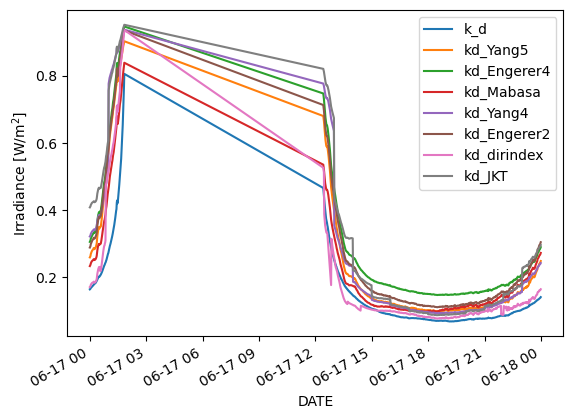

In [50]:
df.loc['2017-06-17', ['k_d','kd_Yang5','kd_Engerer4', 'kd_Mabasa','kd_Yang4','kd_Engerer2','kd_dirindex','kd_JKT']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

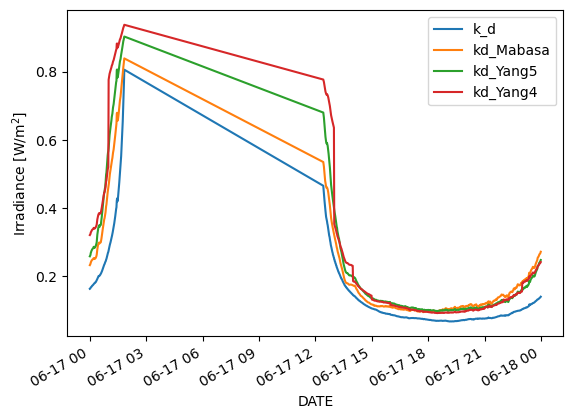

In [51]:
df.loc['2017-06-17', ['k_d','kd_Mabasa','kd_Yang5','kd_Yang4']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

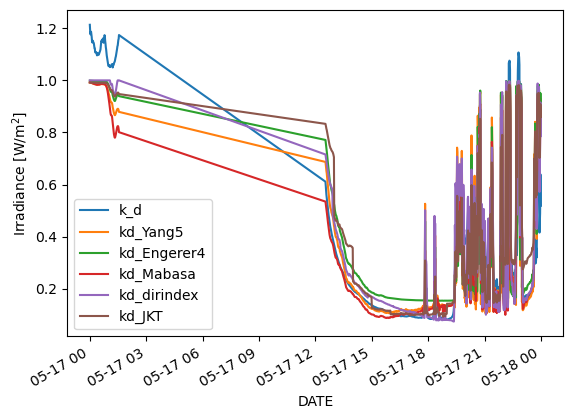

In [52]:
df.loc['2017-05-17', ['k_d','kd_Yang5','kd_Engerer4', 'kd_Mabasa','kd_dirindex','kd_JKT']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

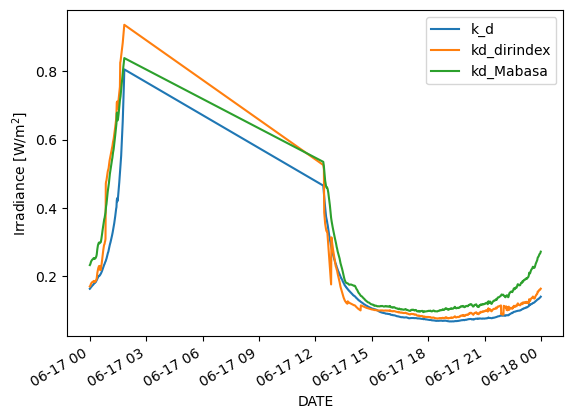

In [53]:
df.loc['2017-06-17', ['k_d','kd_dirindex','kd_Mabasa']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

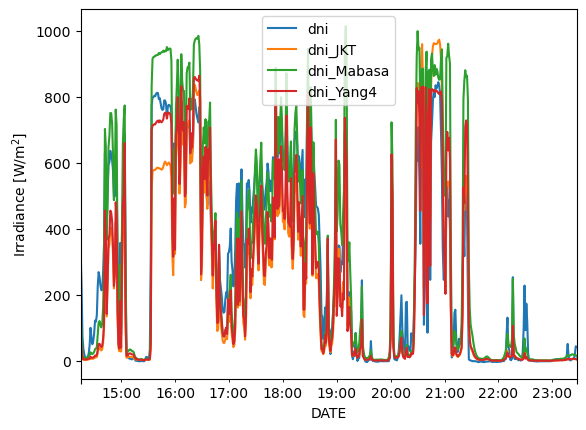

In [54]:
df.loc['2017-11-17', ['dni', 'dni_JKT','dni_Mabasa','dni_Yang4']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

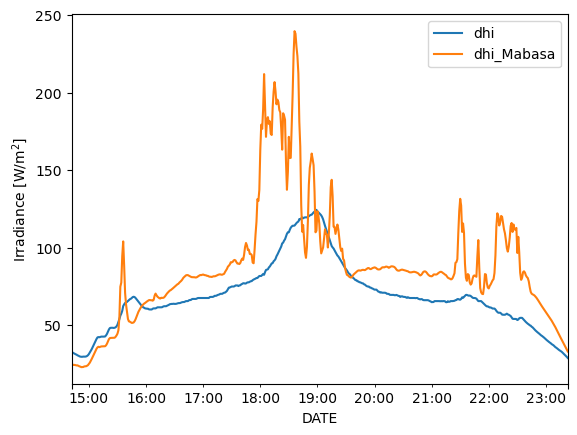

In [55]:
df.loc['2017-12-17', ['dhi','dhi_Mabasa']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

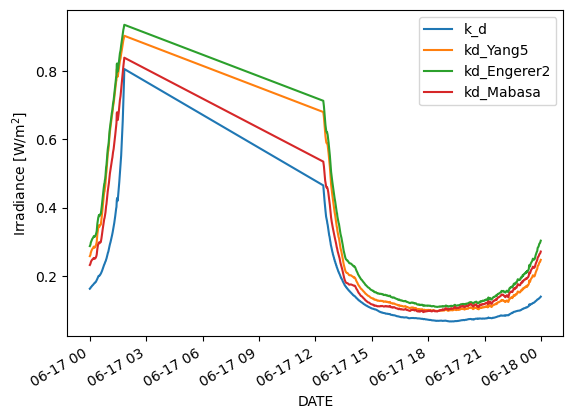

In [56]:
df.loc['2017-06-17', ['k_d','kd_Yang5','kd_Engerer2','kd_Mabasa']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

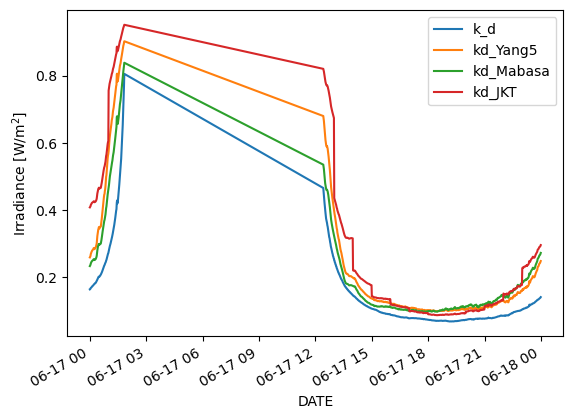

In [57]:
df.loc['2017-06-17', ['k_d','kd_Yang5','kd_Mabasa','kd_JKT']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

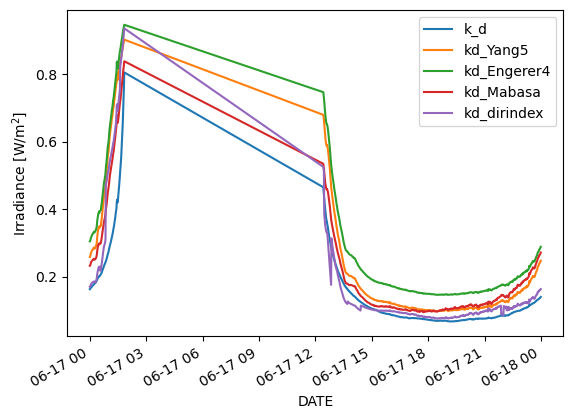

In [58]:
df.loc['2017-06-17', ['k_d','kd_Yang5','kd_Engerer4', 'kd_Mabasa','kd_dirindex']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

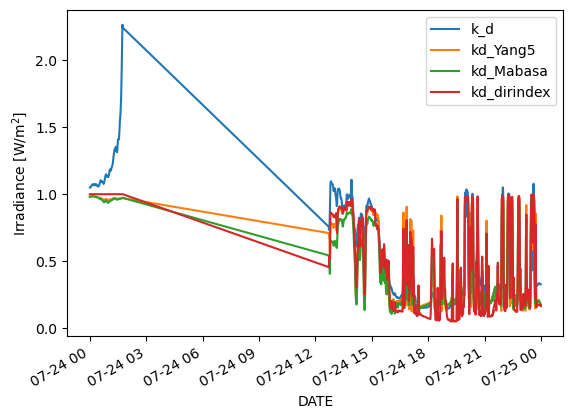

In [59]:
df.loc['2017-07-24', ['k_d','kd_Yang5', 'kd_Mabasa','kd_dirindex']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

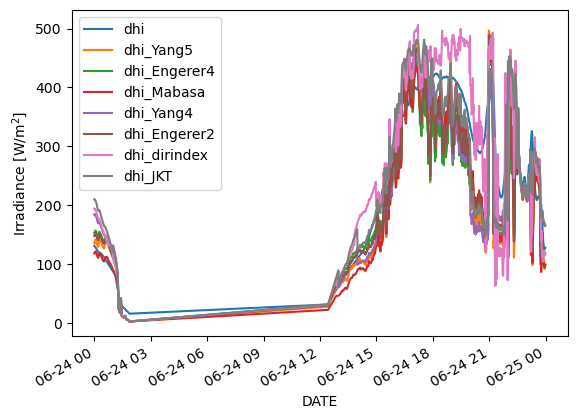

In [60]:
df.loc['2017-06-24', ['dhi','dhi_Yang5','dhi_Engerer4', 'dhi_Mabasa','dhi_Yang4','dhi_Engerer2','dhi_dirindex','dhi_JKT']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

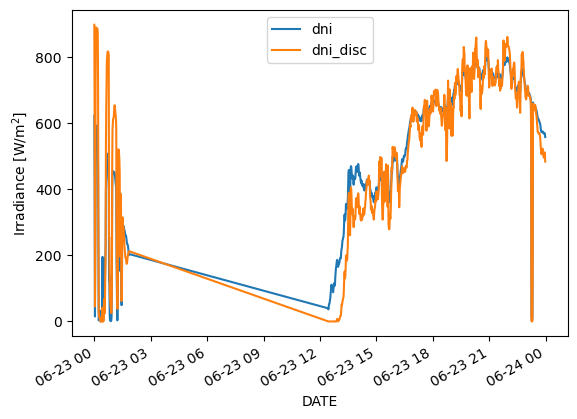

In [61]:
df.loc['2017-06-23', ['dni','dni_disc']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

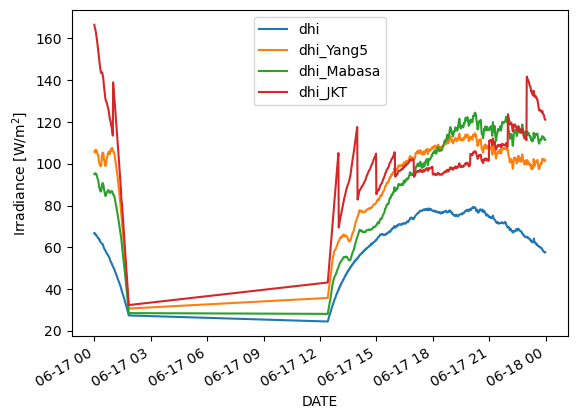

In [62]:
df.loc['2017-06-17', ['dhi','dhi_Yang5', 'dhi_Mabasa','dhi_JKT']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

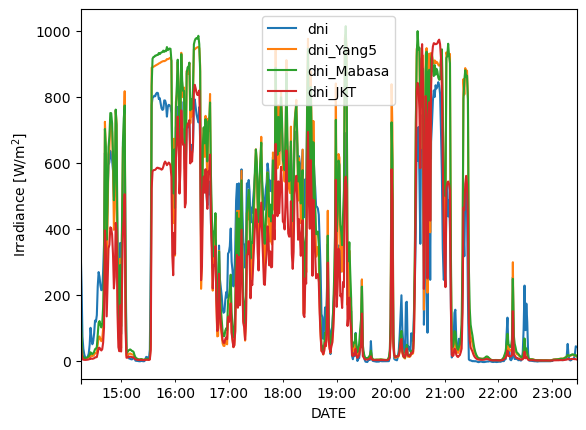

In [63]:
df.loc['2017-11-17', ['dni','dni_Yang5', 'dni_Mabasa','dni_JKT']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

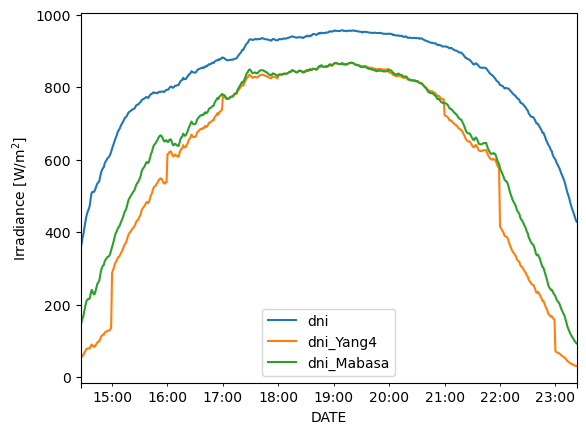

In [64]:
df.loc['2017-11-27', ['dni','dni_Yang4','dni_Mabasa']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

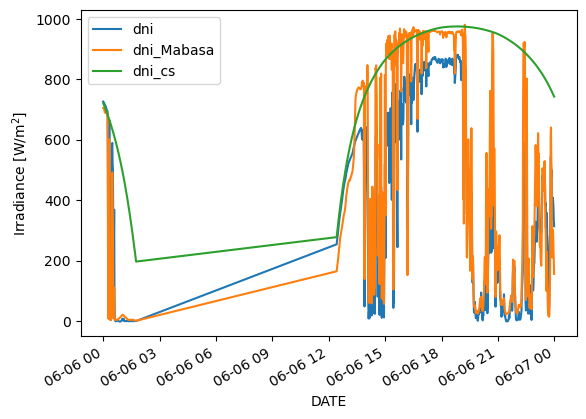

In [65]:
df.loc['2017-06-06', ['dni','dni_Mabasa','dni_cs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

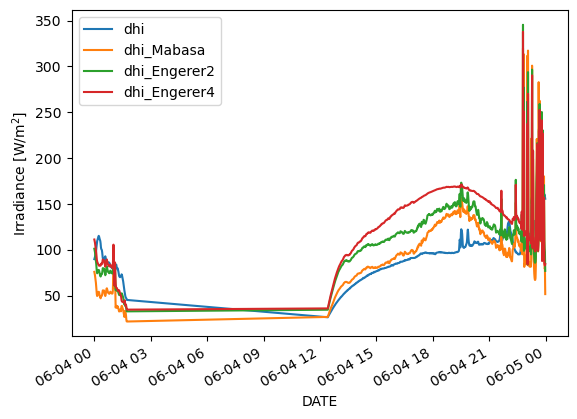

In [66]:
df.loc['2017-06-04', ['dhi','dhi_Mabasa','dhi_Engerer2','dhi_Engerer4']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

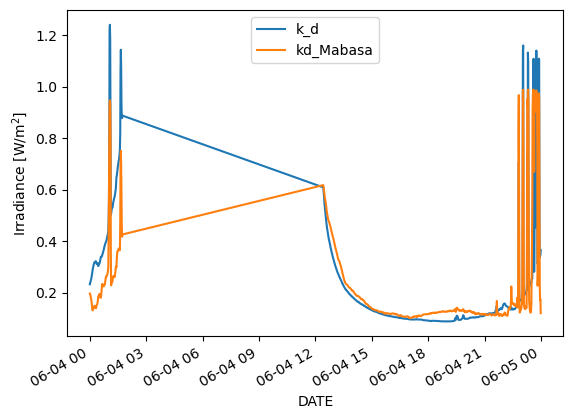

In [67]:
df.loc['2017-06-04', ['k_d','kd_Mabasa']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

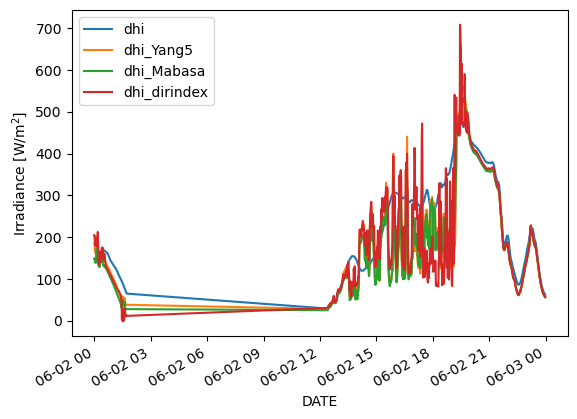

In [68]:
df.loc['2017-06-02', ['dhi','dhi_Yang5', 'dhi_Mabasa','dhi_dirindex']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

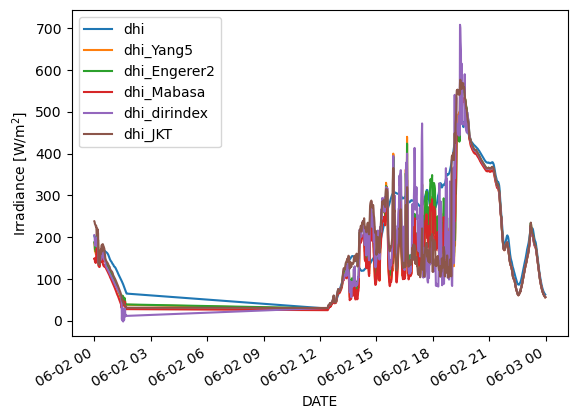

In [69]:
df.loc['2017-06-02', ['dhi','dhi_Yang5','dhi_Engerer2', 'dhi_Mabasa','dhi_dirindex','dhi_JKT']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

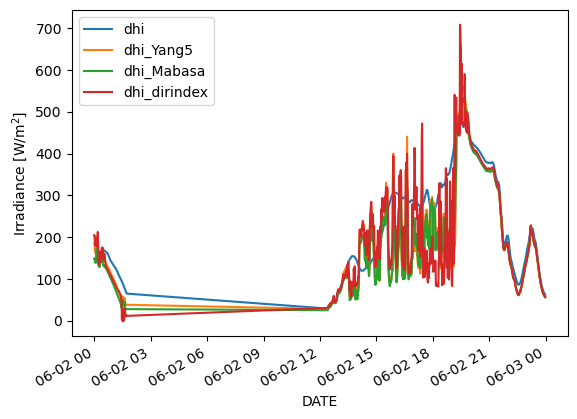

In [70]:
df.loc['2017-06-02', ['dhi','dhi_Yang5', 'dhi_Mabasa','dhi_dirindex']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

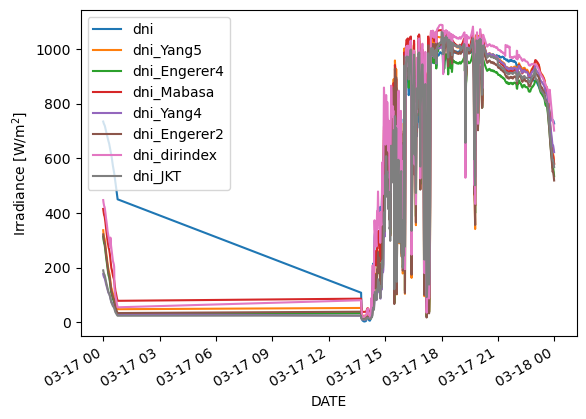

In [71]:
df.loc['2017-03-17', ['dni','dni_Yang5','dni_Engerer4','dni_Mabasa','dni_Yang4','dni_Engerer2','dni_dirindex','dni_JKT']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

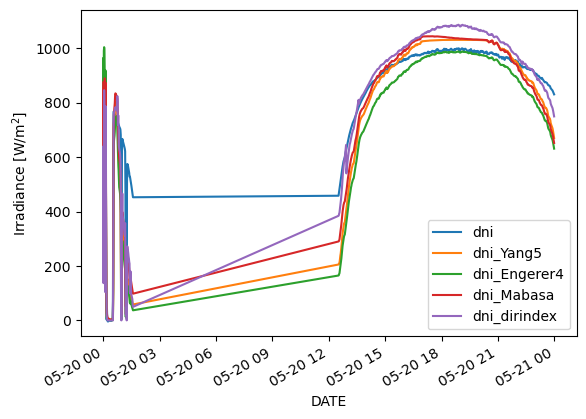

In [72]:
df.loc['2017-05-20', ['dni','dni_Yang5','dni_Engerer4','dni_Mabasa','dni_dirindex']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

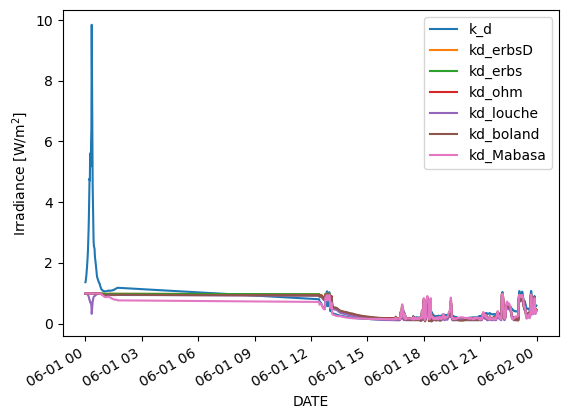

In [73]:
df.loc['2017-06-01', ['k_d','kd_erbsD','kd_erbs','kd_ohm','kd_louche','kd_boland','kd_Mabasa']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

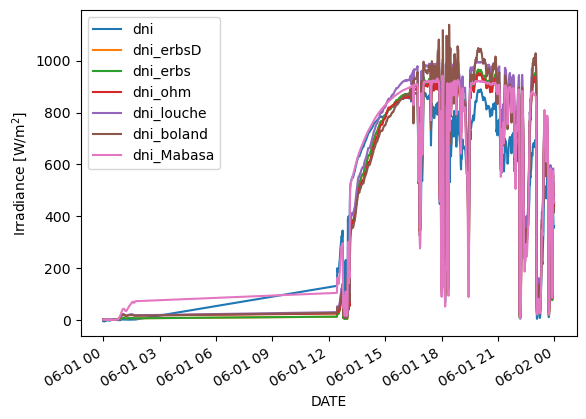

In [74]:
df.loc['2017-06-01', ['dni','dni_erbsD','dni_erbs','dni_ohm','dni_louche','dni_boland','dni_Mabasa']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

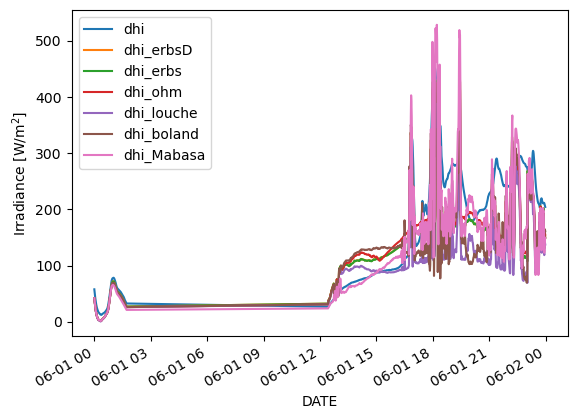

In [75]:
df.loc['2017-06-01', ['dhi','dhi_erbsD','dhi_erbs','dhi_ohm','dhi_louche','dhi_boland','dhi_Mabasa']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [76]:
df.columns

Index(['solar_zenithX', 'ghi', 'dhi', 'dni', 'temp_air', 'relative_humidity',
       'temp_dew', 'pw', 'zenith', 'solar_zenith', 'cos_solar_zenith',
       'dni_extra', 'ghi_extra', 'equation_of_time', 'hour_angle', 'ast',
       'airmass', 'ghi_cs', 'dni_cs', 'dhi_cs', 'ghi_extra_Mclear', 'kn',
       'k_t', 'k_d', 'k_tcsi', 'k_tc', 'dk_tc', 'k_de', 'k_tprime', 'K_t',
       'K_tdaily', 'K_T', 'K_D', 'VI_s', 'VI_p', 'persistence', 'dni_erbs',
       'dhi_erbs', 'kd_erbs', 'dni_erbsD', 'dhi_erbsD', 'kd_erbsD', 'dni_ohm',
       'dhi_ohm', 'kd_ohm', 'dni_louche', 'dhi_louche', 'kd_louche',
       'dni_boland', 'dhi_boland', 'kd_boland', 'dni_disc', 'dhi_disc',
       'kd_disc', 'dni_dirint', 'dhi_dirint', 'kd_dirint', 'dni_dirindex',
       'dhi_dirindex', 'kd_dirindex', 'kd_Engerer2', 'dhi_Engerer2',
       'dni_Engerer2', 'kd_Engerer2H', 'kd_Engerer3', 'dhi_Engerer3',
       'dni_Engerer3', 'kd_Engerer4', 'dhi_Engerer4', 'dni_Engerer4',
       'kd_Mabasa', 'dhi_Mabasa', 'dni_Mabasa', 

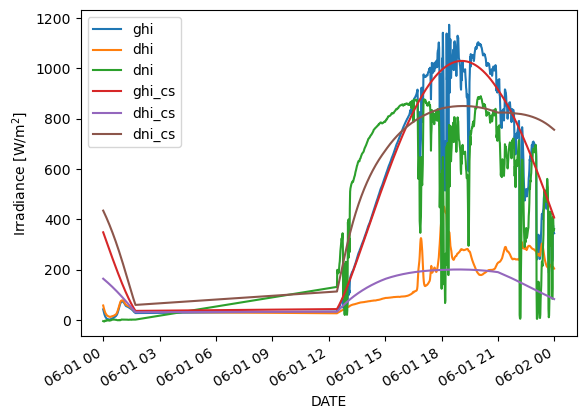

In [77]:
#It is often helpful to visualize the data in order to check that the measurements are within the expected ones. 
df.loc['2017-06-01', ['ghi','dhi','dni','ghi_cs','dhi_cs','dni_cs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

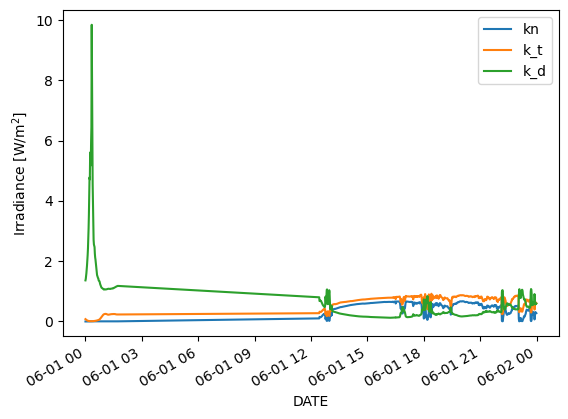

In [78]:
df.loc['2017-06-01', ['kn','k_t','k_d']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

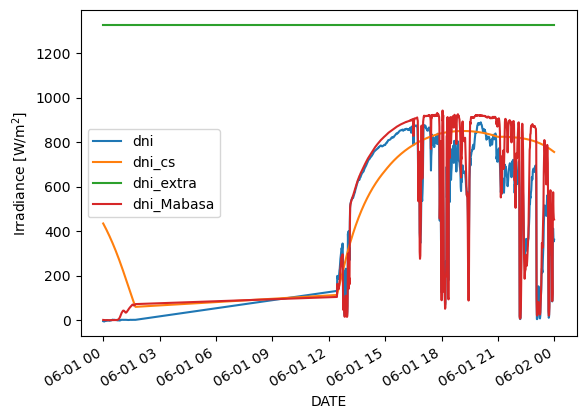

In [79]:
df.loc['2017-06-01', ['dni','dni_cs','dni_extra','dni_Mabasa']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

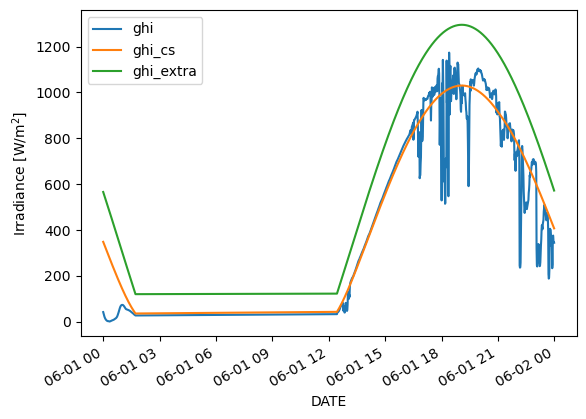

In [80]:
df.loc['2017-06-01', ['ghi','ghi_cs','ghi_extra']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

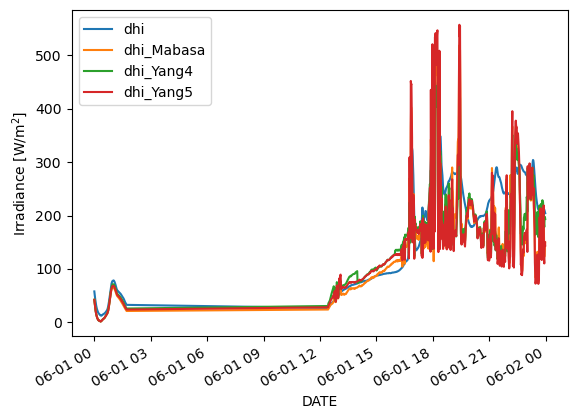

In [81]:
df.loc['2017-06-01', ['dhi','dhi_Mabasa','dhi_Yang4', 'dhi_Yang5']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [82]:
#df.columns

In [83]:
df = df[df['k_d'] < 1]

In [84]:
df[['zenith', 'k_d', 'kd_erbs', 'kd_erbsD','kd_ohm', 'kd_louche','kd_boland','kd_disc', 'kd_dirint','kd_dirindex','kd_Engerer2','kd_Engerer3','kd_Engerer4','kd_Yang5','kd_Yang4','kd_JKT','kd_Mabasa','k_de',]].to_csv('ABQ_2017_KD.csv')

In [85]:
df[[ 'zenith', 'dhi', 'dhi_erbs', 'dhi_erbsD','dhi_ohm', 'dhi_louche','dhi_boland','dhi_disc', 'dhi_dirint','dhi_dirindex','dhi_Engerer2','dhi_Engerer3','dhi_Engerer4','dhi_Yang5','dhi_Yang4','dhi_JKT','dhi_Mabasa']].to_csv('ABQ_2017_dhi.csv')

In [86]:
df[[ 'zenith', 'dni', 'dni_erbs', 'dni_erbsD','dni_ohm', 'dni_louche','dni_boland','dni_disc', 'dni_dirint','dni_dirindex','dni_Engerer2','dni_Engerer3','dni_Engerer4','dni_Yang5','dni_Yang4','dni_JKT','dni_Mabasa']].to_csv('ABQ_2017_dni.csv')

In [87]:
df[['ghi', 'dhi', 'dni', 'temp_air', 'relative_humidity', 'ghi_cs',
       'dhi_cs', 'dni_cs', 'temp_dew', 'pw', 'zenith', 'solar_zenith',
       'equation_of_time', 'hour_angle', 'ast', 'airmass', 'ghi_extra',
       'dni_extra', 'kn', 'k_t', 'k_d', 'k_tcsi', 'k_tc', 'dk_tc', 'k_de',
       'k_tprime', 'K_t', 'K_tdaily', 'K_T', 'K_D', 'VI_s', 'VI_p',
       'persistence', 'dni_erbs', 'dhi_erbs', 'kd_erbs', 'dni_erbsD',
       'dhi_erbsD', 'kd_erbsD', 'dni_ohm', 'dhi_ohm', 'kd_ohm', 'dni_louche',
       'dhi_louche', 'kd_louche', 'dni_boland', 'dhi_boland', 'kd_boland',
       'dni_disc', 'dhi_disc', 'kd_disc', 'dni_dirint', 'dhi_dirint',
       'kd_dirint', 'dni_dirindex', 'dhi_dirindex', 'kd_dirindex',
       'kd_Engerer3', 'dhi_Engerer3', 'dni_Engerer3', 'kd_Engerer2',
       'dhi_Engerer2', 'dni_Engerer2', 'kd_Engerer4', 'dhi_Engerer4',
       'dni_Engerer4', 'kd_Engerer2H', 'kd_Mabasa', 'dhi_Mabasa', 'dni_Mabasa',
       'kd_Yang4', 'dhi_Yang4', 'dni_Yang4', 'kd_Yang5', 'dhi_Yang5',
       'dni_Yang5', 'kd_JKT', 'dhi_JKT', 'dni_JKT']].to_csv('DAA_2017_KD_DNI_DHI.csv')

In [88]:
feature_names = ['k_d','k_t','k_tcsi', 'k_tc', 'dk_tc','k_de', 'k_tprime', 'K_t', 'K_tdaily','zenith','ast','airmass','VI_s', 'VI_p','persistence', 'kd_Engerer4','ghi_cs','kd_Engerer2H','kd_Yang5']
df_features = df[feature_names]
df_features = df_features.sort_index()
df_features.head()

,k_d,k_t,k_tcsi,k_tc,dk_tc,k_de,k_tprime,K_t,K_tdaily,zenith,ast,airmass,VI_s,VI_p,persistence,kd_Engerer4,ghi_cs,kd_Engerer2H,kd_Yang5
DATE,,,,,,,,,,,,,,,,,,,
2017-01-01 16:59:00+00:00,0.999476,0.328856,0.430984,0.763035,0.434179,0.0,0.306807,0.336141,0.148084,65.801731,9.812334,2.425789,0.010359,0.007404,0.330893,0.971137,443.172,0.964818,0.952725
2017-01-01 17:00:00+00:00,0.998482,0.338756,0.443660,0.763548,0.424792,0.0,0.316112,0.489389,0.148084,65.690040,9.828995,2.415461,0.015009,0.010866,0.340425,0.967336,445.386,0.785080,0.949055
2017-01-01 17:01:00+00:00,0.997575,0.351995,0.460685,0.764068,0.412073,0.0,0.328538,0.489389,0.148084,65.579012,9.845656,2.405290,0.016955,0.012381,0.351944,0.961466,447.594,0.785080,0.943600
2017-01-01 17:02:00+00:00,0.997672,0.365132,0.477569,0.764565,0.399432,0.0,0.340874,0.489389,0.148084,65.468649,9.862317,2.395273,0.014500,0.010474,0.363136,0.954650,449.778,0.785080,0.937530
2017-01-01 17:03:00+00:00,0.999095,0.374277,0.489207,0.765070,0.390792,0.0,0.349487,0.489389,0.148084,65.358955,9.878979,2.385406,0.008619,0.005750,0.371211,0.949283,451.956,0.785080,0.932921


In [89]:
#df[['k_d','k_t','k_tcsi', 'k_tc', 'dk_tc','k_de', 'k_tprime', 'K_t', 'K_tdaily','zenith','ast','airmass','VI_s', 'VI_p','persistence', 'k_dengerer2']].to_csv('DAA_2017.csv')


In [90]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207766 entries, 2017-01-01 16:59:00+00:00 to 2017-12-31 23:29:00+00:00
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   k_d           207766 non-null  float64
 1   k_t           207766 non-null  float64
 2   k_tcsi        207766 non-null  float64
 3   k_tc          207766 non-null  float64
 4   dk_tc         207766 non-null  float64
 5   k_de          207766 non-null  float64
 6   k_tprime      207766 non-null  float64
 7   K_t           207766 non-null  float64
 8   K_tdaily      207766 non-null  float64
 9   zenith        207766 non-null  float64
 10  ast           207766 non-null  float64
 11  airmass       207766 non-null  float64
 12  VI_s          207766 non-null  float64
 13  VI_p          207766 non-null  float64
 14  persistence   207766 non-null  float64
 15  kd_Engerer4   207766 non-null  float64
 16  ghi_cs        207766 non-null  float64
 17  kd

In [91]:
print(df_features.describe().to_markdown())

|       |           k_d |            k_t |        k_tcsi |           k_tc |           dk_tc |          k_de |       k_tprime |           K_t |      K_tdaily |      zenith |          ast |      airmass |             VI_s |             VI_p |   persistence |   kd_Engerer4 |     ghi_cs |   kd_Engerer2H |       kd_Yang5 |
|:------|--------------:|---------------:|--------------:|---------------:|----------------:|--------------:|---------------:|--------------:|--------------:|------------:|-------------:|-------------:|-----------------:|-----------------:|--------------:|--------------:|-----------:|---------------:|---------------:|
| count | 207766        | 207766         | 207766        | 207766         | 207766          | 207766        | 207766         | 207766        | 207766        | 207766      | 207766       | 207766       | 207766           | 207766           | 207766        | 207766        | 207766     |  207766        | 207766         |
| mean  |      0.26798  |      0.684018 

In [92]:
#df2 = df[df['tcc'] >= 95]
#df2 = df[df['k_t'] <= 0.35]

#df3 = df[df['k_t'] > 0.65]
#df3 = df[df['tcc'] <= 5]
#df3 = df[df['k_t'] <= 5]

In [93]:
#df2[['tcc', 'zenith', 'k_d', 'kd_erbs', 'kd_erbsD','kd_ohm', 'kd_louche','kd_boland','kd_disc', 'kd_dirint','kd_dirindex','kd_Engerer2','kd_Engerer3','kd_Engerer4','kd_Yang5','kd_Yang4','kd_JKT','kd_Mabasa','k_de',]].to_csv('DAA_2017_KD_OVERCAST.csv')
#df3[['tcc', 'zenith', 'k_d', 'kd_erbs', 'kd_erbsD','kd_ohm', 'kd_louche','kd_boland','kd_disc', 'kd_dirint','kd_dirindex','kd_Engerer2','kd_Engerer3','kd_Engerer4','kd_Yang5','kd_Yang4','kd_JKT','kd_Mabasa','k_de',]].to_csv('DAA_2017_KD_CLEARSKY.csv')
#df2[['tcc', 'zenith', 'dhi', 'dhi_erbs', 'dhi_erbsD','dhi_ohm', 'dhi_louche','dhi_boland','dhi_disc', 'dhi_dirint','dhi_dirindex','dhi_Engerer2','dhi_Engerer3','dhi_Engerer4','dhi_Yang5','dhi_Yang4','dhi_JKT','dhi_Mabasa']].to_csv('DAA_2017_dhi_OVERCAST.csv')
#df3[['tcc', 'zenith', 'dhi', 'dhi_erbs', 'dhi_erbsD','dhi_ohm', 'dhi_louche','dhi_boland','dhi_disc', 'dhi_dirint','dhi_dirindex','dhi_Engerer2','dhi_Engerer3','dhi_Engerer4','dhi_Yang5','dhi_Yang4','dhi_JKT','dhi_Mabasa']].to_csv('DAA_2017_dhi_CLEARSKY.csv')
#df2[['tcc', 'zenith', 'dni', 'dni_erbs', 'dni_erbsD','dni_ohm', 'dni_louche','dni_boland','dni_disc', 'dni_dirint','dni_dirindex','dni_Engerer2','dni_Engerer3','dni_Engerer4','dni_Yang5','dni_Yang4','dni_JKT','dni_Mabasa']].to_csv('DAA_2017_dni_OVERCAST.csv')
#df3[['tcc', 'zenith', 'dni', 'dni_erbs', 'dni_erbsD','dni_ohm', 'dni_louche','dni_boland','dni_disc', 'dni_dirint','dni_dirindex','dni_Engerer2','dni_Engerer3','dni_Engerer4','dni_Yang5','dni_Yang4','dni_JKT','dni_Mabasa']].to_csv('DAA_2017_dni_CLEARSKY.csv')